In [37]:
# 
# DATeS: Data Assimilation Testing Suite.
# Jupyter Tutorials.
#

# An example of a test driver:
# ==============================
# The driver file should be located in the root directory of DATeS.
# So; if it is not there, make a copy in the DATES_ROOT_PATH!
#
#     1- Create an object of the Quasi-Geostrophic 'qg1p5' model;
#     2- Create an of a Deterministic DEnKF;
#     3- Run EnKF using Lorenz96 over a defined observation, and assimilation timespan.
# 
#     To Run the driver:
#        On the linux terminal execute the following command:
#            $ python lorenze96_enkf_test_driver.py
#

In [38]:
import sys
import numpy as np

In [39]:
# Define environment variables and update Python search path;
# this is a necessary call that must be inserted in the beginning of any driver.

import dates_setup
dates_setup.initialize_dates(random_seed=2345)

import dates_utility as utility  # import DATeS utility module(s)

In [40]:
# Create a model object

from qg_1p5_model import QG1p5
model = QG1p5(model_configs = dict(MREFIN=7, model_name='QG-1.5',
                                   model_grid_type='cartesian',
                                   observation_operator_type='linear',
                                   observation_vector_size=300,
                                   observation_error_variances=4.0,
                                   observation_errors_covariance_method='diagonal',
                                   background_error_variances=5.0,
                                   background_errors_covariance_method='diagonal',
                                   )
           )  # MREFIN = 5, 6, 7 for the three models QGt, QGs, QG respectively

--------------------------------------------------
	>>>>>> GQ-Model 1.5. <<<<<<
--------------------------------------------------
	+ Model grid-size: 129 x 129
	+ Started creating wrapper function...
--------------------------------------------------
	Wrapper created successfully!
--------------------------------------------------


In [41]:
# Create DA pieces; this includes:
# ---------------------------------
#   i-   forecast trajectory/state
#   ii-  initial ensemble, 
#   iii- filter/smoother/hybrid object.

In [42]:
# create observations' and assimilation checkpoints:

obs_checkpoints = np.arange(0, 1250.5001, 50)/4.0
da_checkpoints = obs_checkpoints

In [43]:
# create initial ensemble:

ensemble_size = 20
initial_ensemble = model.create_initial_ensemble(ensemble_size=ensemble_size, ensemble_from_repo=True)

In [44]:
# import, configure, and create filter object:

from EnKF import DEnKF as DeterministicEnKF
enkf_filter_configs = dict(model=model,
                           analysis_ensemble=initial_ensemble,
                           forecast_ensemble=None,
                           ensemble_size=ensemble_size,
                           inflation_factor=1.06,
                           obs_covariance_scaling_factor=1.0,
                           obs_adaptive_prescreening_factor=None,
                           localize_covariances=True,
                           localization_method='covariance_filtering',
                           localization_radius=12,
                           localization_function='Gaspari-Cohn',
                           )

filter_obj = DeterministicEnKF(filter_configs=enkf_filter_configs, 
                               output_configs=dict(file_output_moment_only=False)
                               )


In [45]:
# Create sequential DA process:
# -----------------------------

# + processing object; here this is a filtering_process object:

from filtering_process import FilteringProcess
experiment = FilteringProcess(assimilation_configs=dict(model=model,
                                                        filter=filter_obj,
                                                        obs_checkpoints=obs_checkpoints,
                                                        da_checkpoints=da_checkpoints,
                                                        forecast_first=True,
                                                        ref_initial_condition=model._reference_initial_condition.copy(),
                                                        ref_initial_time=0
                                                        ),
                              output_configs = dict(scr_output=True,
                                                    scr_output_iter=1,
                                                    file_output=True,
                                                    file_output_iter=1)
                              )

Caution: Unknown key detected: 'model'. Ignored and defaults are restored if necessary


In [46]:
# run the sequential filtering over the timespan created by da_checkpoints

experiment.recursive_assimilation_process()

Filtering:DEnKF: FORECAST[time:1.250e+01 > RMSE:5.83742e+00]  :: ANALYSIS[time:1.250e+01 > RMSE:3.02137e+00]
Filtering:DEnKF: FORECAST[time:2.500e+01 > RMSE:3.04408e+00]  :: ANALYSIS[time:2.500e+01 > RMSE:2.87385e+00]
Filtering:DEnKF: FORECAST[time:3.750e+01 > RMSE:2.88619e+00]  :: ANALYSIS[time:3.750e+01 > RMSE:2.65407e+00]
Filtering:DEnKF: FORECAST[time:5.000e+01 > RMSE:2.66195e+00]  :: ANALYSIS[time:5.000e+01 > RMSE:2.74206e+00]
Filtering:DEnKF: FORECAST[time:6.250e+01 > RMSE:2.75528e+00]  :: ANALYSIS[time:6.250e+01 > RMSE:2.32915e+00]
Filtering:DEnKF: FORECAST[time:7.500e+01 > RMSE:2.32411e+00]  :: ANALYSIS[time:7.500e+01 > RMSE:2.05381e+00]
Filtering:DEnKF: FORECAST[time:8.750e+01 > RMSE:2.06379e+00]  :: ANALYSIS[time:8.750e+01 > RMSE:1.80083e+00]
Filtering:DEnKF: FORECAST[time:1.000e+02 > RMSE:1.81982e+00]  :: ANALYSIS[time:1.000e+02 > RMSE:1.78137e+00]
Filtering:DEnKF: FORECAST[time:1.125e+02 > RMSE:1.80841e+00]  :: ANALYSIS[time:1.125e+02 > RMSE:1.53235e+00]
Filtering:DEnKF: FO

In [47]:
# retrieve/read  results:
from filtering_results_reader import read_filter_output
out_dir_tree_structure_file = 'Results/Filtering_Results/output_dir_structure.txt'
filtering_results = read_filter_output(out_dir_tree_structure_file)

num_cycles = filtering_results[1]
reference_states = filtering_results[2]
forecast_ensembles = filtering_results[3]
forecast_means = filtering_results[4]
analysis_ensembles = filtering_results[5]
analysis_means = filtering_results[6]
forecast_times = filtering_results[8]
analysis_times = filtering_results[9]
forecast_rmse = filtering_results[11]
analysis_rmse = filtering_results[12]
filter_configs = filtering_results[13]

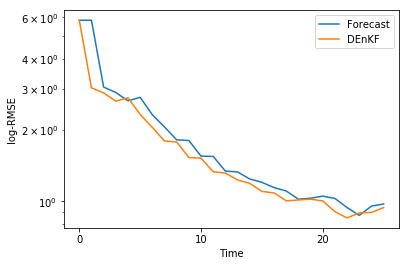

In [48]:
# 1- plot RMSE:

import matplotlib.pyplot as plt

fig_rmse = plt.figure(facecolor='white')
plt.semilogy(forecast_times, forecast_rmse, label='Forecast')
plt.semilogy(analysis_times, analysis_rmse, label=filter_configs['filter_name'])

plt.xlabel('Time')
plt.ylabel('log-RMSE')
xlables = [forecast_times[i] for i in xrange(0, len(forecast_times), 10)]
plt.xticks(xlables, 10*np.arange(len(xlables)))

plt.legend(loc='upper right')
plt.show()

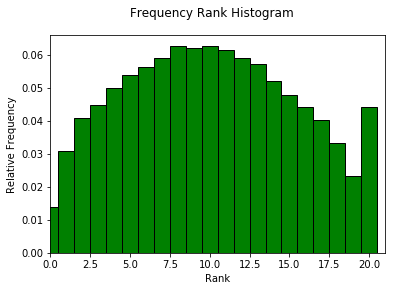

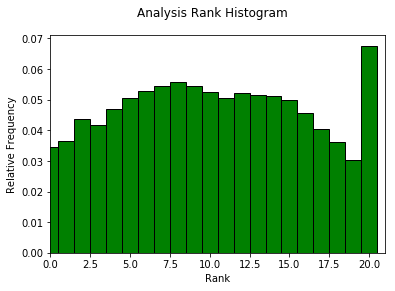

In [49]:
# 2- plot rank histogrmas:
_ = utility.rank_hist(forecast_ensembles, 
                      reference_states,
                      first_var=0, 
                      last_var=None, 
                      var_skp=1, 
                      draw_hist=True, 
                      hist_type='relfreq', 
                      first_time_ind=20, 
                      last_time_ind=None,
                      time_ind_skp=1, 
                      hist_title= 'Frequency Rank Histogram'
                     )
_ = utility.rank_hist(analysis_ensembles,
                      reference_states,
                      first_var=0, 
                      last_var=None, 
                      var_skp=15, 
                      draw_hist=True, 
                      hist_type='relfreq', 
                      first_time_ind=2, 
                      last_time_ind=None,
                      time_ind_skp=1, 
                      hist_title= 'Analysis Rank Histogram'
                      )
plt.show()

In [50]:
# Show trajectories:
from matplotlib import animation, rc
from IPython.display import HTML

state_size = model.state_size()
nx = int(np.sqrt(state_size))
ny = int(state_size/nx)

# Plot reference trajectory:
fig = plt.figure(facecolor='white')
fig.suptitle("Reference Trajectory")
ims = []
for ind in xrange(num_cycles):
    state = np.reshape(np.squeeze(reference_states[:, ind]), (nx, ny), order='F')
    imgplot = plt.imshow(state, animated=True)
    if ind == 0:
        plt.colorbar()
    else:
        plt.autoscale()
    ims.append([imgplot])

anim_ref = animation.ArtistAnimation(fig, ims, interval=75, blit=True, repeat_delay=1000)
HTML(anim_ref.to_html5_video())

In [51]:
# Plot Forecast trajectory:
fig = plt.figure(facecolor='white')
fig.suptitle("Forecast Trajectory")
ims = []
for ind in xrange(num_cycles):
    state = np.reshape(np.squeeze(forecast_means[:, ind]), (nx, ny), order='F')
    imgplot = plt.imshow(state, animated=True)
    if ind == 0:
        plt.colorbar()
    else:
        plt.autoscale()
    ims.append([imgplot])

anim_frcst = animation.ArtistAnimation(fig, ims, interval=75, blit=True, repeat_delay=1000)
HTML(anim_frcst.to_html5_video())

In [52]:
# Plot Analysis trajectory:
fig = plt.figure(facecolor='white')
fig.suptitle("Analysis Trajectory")
ims = []
for ind in xrange(num_cycles):
    state = np.reshape(np.squeeze(analysis_means[:, ind]), (nx, ny), order='F')
    imgplot = plt.imshow(state, animated=True)
    if ind == 0:
        plt.colorbar()
    else:
        plt.autoscale()
    ims.append([imgplot])

anim_anls = animation.ArtistAnimation(fig, ims, interval=75, blit=True, repeat_delay=1000)
HTML(anim_anls.to_html5_video())

In [53]:
# Plot Forecast Error trajectory:
fig = plt.figure(facecolor='white')
fig.suptitle("Forecast Errors")
ims = []
for ind in xrange(num_cycles):
    state = np.reshape(np.squeeze(reference_states[:, ind]-forecast_means[:, ind]), (nx, ny), order='F')
    imgplot = plt.imshow(state, animated=True)
    if ind == 0:
        plt.colorbar()
    else:
        plt.autoscale()
    ims.append([imgplot])

anim_frcst_err = animation.ArtistAnimation(fig, ims, interval=75, blit=True, repeat_delay=1000)
HTML(anim_frcst_err.to_html5_video())

In [54]:
# Plot Analysis Error trajectory:
fig = plt.figure(facecolor='white')
fig.suptitle("Analysis Errors")
ims = []
for ind in xrange(num_cycles):
    state = np.reshape(np.squeeze(reference_states[:, ind]-analysis_means[:, ind]), (nx, ny), order='F')
    imgplot = plt.imshow(state, animated=True)
    if ind == 0:
        plt.colorbar()
    else:
        plt.autoscale()
    ims.append([imgplot])

anim_anls_err = animation.ArtistAnimation(fig, ims, interval=75, blit=True, repeat_delay=1000)
HTML(anim_anls_err.to_html5_video())

In [55]:
# Clean executables and temporary modules:

utility.clean_executable_files()